<a href="https://colab.research.google.com/github/looloo404/Object_Detection/blob/master/opencv_yolov3_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OpenCV Darknet Yolo를 이용한 Object Detection**

Yolo v3 특징 -> FPN 사용, 3개의 다른 피처맵에서 AnchorBox 추출


## **Yolo v3의 구성도**
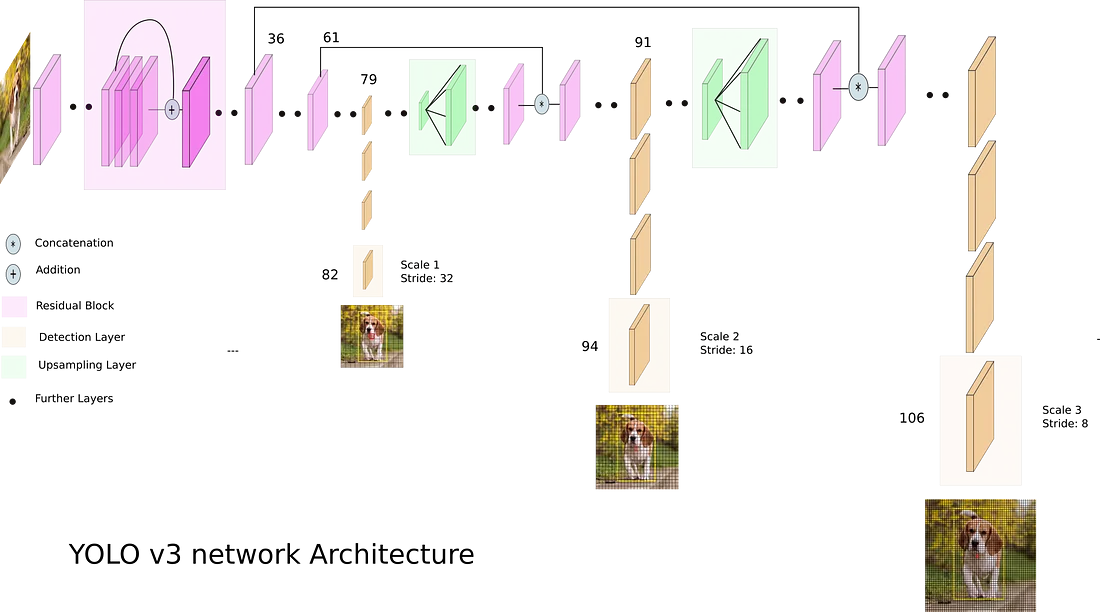

*참조:  https://miro.medium.com/v2/resize:fit:1100/format:webp/1*d4Eg17IVJ0L41e7CTWLLSg.png

In [1]:
# 이미지 다운로드
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2023-08-01 20:17:05--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.006s  

2023-08-01 20:17:05 (60.5 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



 MMDetection과 비슷하게 opencv에서도 config 파일과 pretrained된 weights 파일이 필요하다.

 파일 링크 : https://pjreddie.com/darknet/yolo/ 사이트에서 weights 파일 Config 파일 다운로드

다운로드 받는 페이지 :


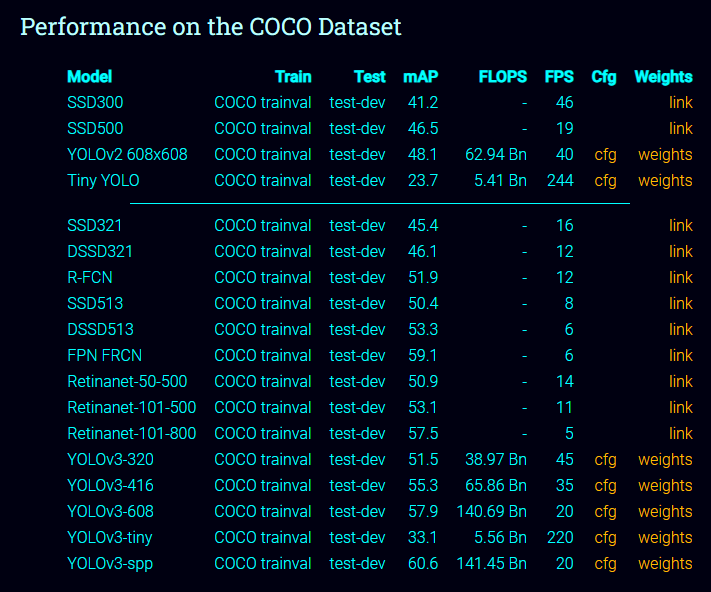


In [2]:
### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드하여 /content/pretrained 디렉토리 아래에 저장.
!mkdir ./pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
# yolov3 => GPU에서는 빠르나 CPU에서는 성능이 SSD보다 나쁘다는 단점이 있다.
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
# yolov3 tiny => Yolo의 성능을 빠르게 한 버전 대신 퍼포먼스가 떨어진다
!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

!ls /content/pretrained

##### downloading pretrained yolo/tiny-yolo weight file and config file
--2023-08-01 20:17:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/pretrained/yolov3.weights’

/content/pretrained 100%[===================>] 236.52M  18.1MB/s    in 14s     

2023-08-01 20:17:21 (16.8 MB/s) - ‘/content/pretrained/yolov3.weights’ saved [248007048/248007048]

--2023-08-01 20:17:21--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2023-08-01 20:17:21--  https://github.c

readNetFromDarknet이용 -> yolo inference Network을 로딩

In [3]:
import os
import cv2

weights_path = '/content/pretrained/yolov3.weights'
cfg_path = '/content/pretrained/yolov3.cfg'

#주의 config인자가 먼저옴
cv_net_yolov3 = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)

COCO class id와 class 명 매핑

In [4]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

3개의 scale Output layer에서 결과 데이터 추출

In [5]:
layer_names = cv_net_yolov3.getLayerNames()
print(' YoloV3 Layer Name : ',layer_names)
# 몇 번째 Layer인지 반환
out_layer_index = cv_net_yolov3.getUnconnectedOutLayers()
print('final output layer id : ',out_layer_index)
# out_layer_index를 통해 out_layer의 layer 이름 검색
out_layer_names = [layer_names[i-1] for i in out_layer_index]
print('out_layer_names : ', out_layer_names)

 YoloV3 Layer Name :  ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv

Yolov3 구성도에서 out layer는 3개 이며 각각의 피처맵의 사이즈는 13x13, 26x26, 52x52이다.

각각의 layer의 한셀당 3개의 AnchorBox가 있다.
한개의 Anchorbox에는 box 모양을 경정짓는 x_center, y_center, width, height가 있으며 COCO Dataset을 사용하였기 때문에 80개의 클래스를 가진다.


###**13 x 13에서 한 셀당 차원수 => 13 x 13 x 3 x 85 = 507 x 85**###

##### *주의 :  3개의 Anchorbox를 가지므로 3을 곱해준다

###**26 x 26에서 한 셀당 차원수 => 26 x 26 x 3 x 85 = 2028 x 85**

###**52 x 52에서 한 셀당 차원수 => 52 x 52 x 3 x 85 = 8112 x 85**

In [6]:
from numpy.core.fromnumeric import size
#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolov3.getLayerNames()

out_layer_names = [layer_names[i-1] for i in out_layer_index]
print('output_layer names:', out_layer_names)

img = cv2.imread('./data/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
cv_net_yolov3.setInput(cv2.dnn.blobFromImage(img,size = (416,416),scalefactor=1/255.,swapRB = False, crop = False))

# Object Detection 수행하여 결과를 cvOut으로 반환
cv_outs = cv_net_yolov3.forward(out_layer_names)
print('cv_outs type : ', type(cv_outs),' ', 'cv_outs의 원소 갯수 : ',len(cv_outs))
print('13 x 13 :',cv_outs[0].shape, '26 x 26 :',cv_outs[1].shape,'52 x 52 :', cv_outs[2].shape)
print(cv_outs)

output_layer names: ['yolo_82', 'yolo_94', 'yolo_106']
cv_outs type :  <class 'tuple'>   cv_outs의 원소 갯수 :  3
13 x 13 : (507, 85) 26 x 26 : (2028, 85) 52 x 52 : (8112, 85)
(array([[0.03657056, 0.0461115 , 0.37111288, ..., 0.        , 0.        ,
        0.        ],
       [0.04505657, 0.03477091, 0.26116827, ..., 0.        , 0.        ,
        0.        ],
       [0.04909464, 0.03695405, 0.7226354 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.95770204, 0.9436839 , 0.32732075, ..., 0.        , 0.        ,
        0.        ],
       [0.9610557 , 0.96345866, 0.28969973, ..., 0.        , 0.        ,
        0.        ],
       [0.96762246, 0.96624655, 0.7931061 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), array([[0.01518789, 0.02484626, 0.04464881, ..., 0.        , 0.        ,
        0.        ],
       [0.0159117 , 0.01443641, 0.44920617, ..., 0.        , 0.        ,
        0.        ],
       [0.02188047, 0.01401338, 0.06500153, ...

Opencv에서 사용할 수 있게끔 x_center y_center width height를 xmin, ymin, xmax, ymax 형태로 바꾼다.

In [16]:
import numpy as np

# 주의 => cv_outs의 box좌표값들은 정규화 되어 있음
rows = img_rgb.shape[0]
cols = img_rgb.shape[1]

# print(rows, cols)

conf_threshold = 0.35
NMS_threshold = 0.4

# bounding box의 테두리와 caption 글자색 지정
green_color = (0,255,0)
red_color = (0,0,255)

class_ids = []
confidences = []
boxes = []

for Feature in cv_outs:
  print('output shape : ',Feature.shape )
  # [0 - 5) 까지는 bbox의 위치 정보 및 confidence score
  # [5- 85)까지는 class socre
  for AnchorBox in Feature :
    class_scores = AnchorBox[5:]
    class_id = np.argmax(class_scores)
    class_confidence = class_scores[class_id]
    box = AnchorBox[:5]
    # if confidence != 0.0:
    #   print(confidence)
    #   break
    # print(type(class_id))
    # if class_id != 0:
    #   print(class_id)
    if class_confidence >= conf_threshold:
      # print(' x_center :',box[0], 'y_center :',box[1], 'width :',box[2], 'height :',box[3] )
      x_center, y_center , width , height = box[:4]
      x_center = int(x_center * cols)
      y_center = int(y_center * rows)
      width = int(width * cols)
      height = int(height * rows)
      left = x_center - width/2
      top = y_center - height/2
      boxes.append((left,top,width,height))
      class_ids.append(class_id)
      confidences.append(float(class_confidence))
  print(len(boxes),boxes)

output shape :  (507, 85)
7 [(25.5, 255.0, 173, 312), (47.0, 254.5, 172, 311), (202.0, 245.5, 186, 305), (246.5, 238.5, 161, 317), (386.0, 271.0, 186, 292), (396.5, 272.5, 211, 291), (569.5, 258.5, 173, 307)]
output shape :  (2028, 85)
24 [(25.5, 255.0, 173, 312), (47.0, 254.5, 172, 311), (202.0, 245.5, 186, 305), (246.5, 238.5, 161, 317), (386.0, 271.0, 186, 292), (396.5, 272.5, 211, 291), (569.5, 258.5, 173, 307), (502.5, 226.0, 71, 68), (499.0, 226.0, 78, 68), (139.5, 239.5, 117, 101), (137.0, 246.0, 118, 96), (254.5, 256.0, 101, 258), (264.5, 252.5, 105, 265), (57.5, 273.0, 121, 268), (67.5, 278.5, 125, 257), (247.0, 253.0, 116, 288), (266.0, 252.0, 106, 290), (410.5, 289.0, 131, 240), (594.0, 266.0, 132, 286), (54.5, 282.0, 125, 268), (62.5, 278.5, 133, 275), (406.0, 288.5, 138, 259), (578.5, 286.0, 135, 264), (590.5, 280.5, 137, 275)]
output shape :  (8112, 85)
37 [(25.5, 255.0, 173, 312), (47.0, 254.5, 172, 311), (202.0, 245.5, 186, 305), (246.5, 238.5, 161, 317), (386.0, 271.0,

In [17]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, NMS_threshold)

idxs

array([ 4,  6, 16, 14, 31, 24, 10, 33,  7, 28, 36, 30, 25, 35],
      dtype=int32)

person: 0.9961
person: 0.9957
person: 0.9945
person: 0.9791
car: 0.9327
car: 0.8744
car: 0.8668
car: 0.8310
car: 0.7739
car: 0.6721
person: 0.5815
car: 0.5060
car: 0.4056
car: 0.3738


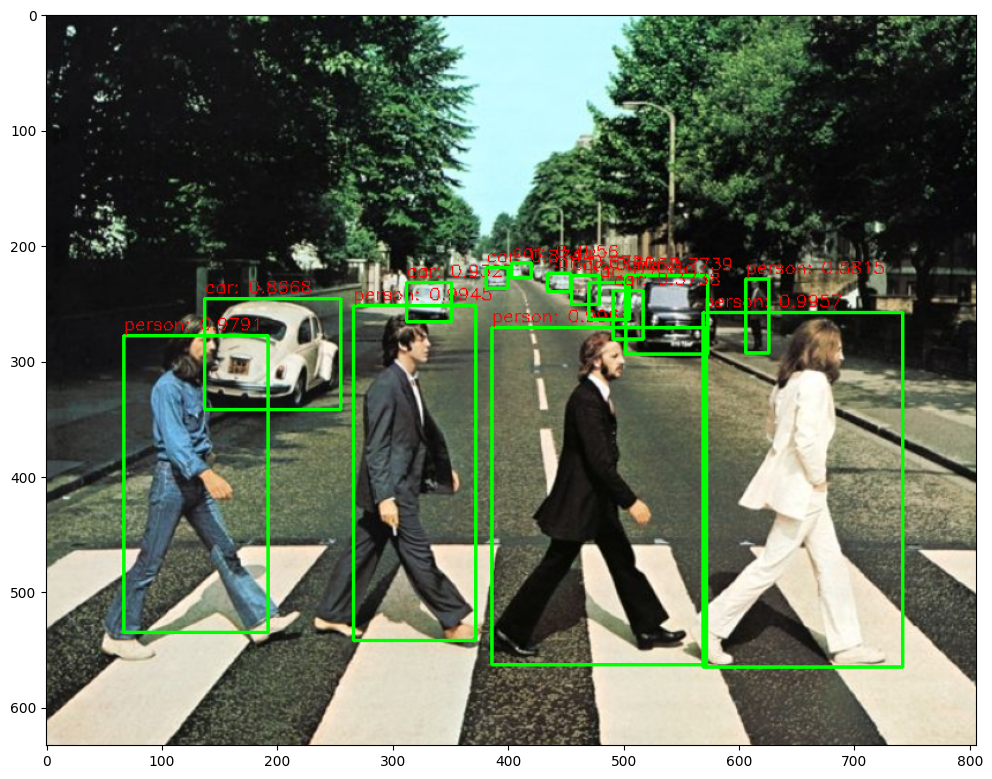

In [18]:
import matplotlib.pyplot as plt

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


